In [127]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from test_utils import test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [87]:
from helpers import load_data

# load dataset
x, y = load_data()

In [88]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.

    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold

    >>> build_k_indices(np.array([1., 2., 3., 4.]), 2, 1)
    array([[3, 2],
           [0, 1]])
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [89]:
test(build_k_indices)

✅ Your `build_k_indices` passes some basic tests.


For the following cross_validation( ) function you need to implement, you can help yourselves of the build_poly( ) and ridge_regression( ) functions that you implemented in lab 3. Copy paste the code in the build_polynomial.py and ridge_regression.py files, they should pass the two following tests.

In [90]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly


test(build_poly)
test(ridge_regression)

Could not find any tests for build_poly
✅ Your `ridge_regression` passes some basic tests.


In [128]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression for a fold corresponding to k_indices

    Args:
        y:          shape=(N,)
        x:          shape=(N,)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        lambda_:    scalar, cf. ridge_regression()
        degree:     scalar, cf. build_poly()

    Returns:
        train and test root mean square errors rmse = sqrt(2 mse)

    >>> cross_validation(np.array([1.,2.,3.,4.]), np.array([6.,7.,8.,9.]), np.array([[3,2], [0,1]]), 1, 2, 3)
    (0.019866645527597114, 0.33555914361295175)
    """
    idx_te = k_indices[k]
    x_te = x[idx_te]
    y_te = y[idx_te]

    idx_tr = np.delete(k_indices, k, axis=0).ravel()
    x_tr = x[idx_tr]
    y_tr = y[idx_tr]

    px_tr = build_poly(x_tr, degree)
    px_te = build_poly(x_te, degree)

    w = ridge_regression(y_tr, px_tr, lambda_)

    N_tr = px_tr.shape[0]
    N_te = px_te.shape[0]

    e_tr = y_tr - px_tr.dot(w)
    mse_tr = 1 / (2 * N_tr) * e_tr.dot(e_tr)
    rmse_tr = float(np.sqrt(2 * mse_tr))

    e_te = y_te - px_te.dot(w)
    mse_te = 1 / (2 * N_te) * e_te.dot(e_te)
    rmse_te = float(np.sqrt(2 * mse_te))

    return rmse_tr, rmse_te

In [129]:
cross_validation(np.array([1.,2.,3.,4.]), np.array([6.,7.,8.,9.]), np.array([[3,2], [0,1]]), 1, 2, 3)

(0.019866645527597114, 0.33555914361295175)

In [130]:
# can lead to a numerical error if you use an older version than Python 3.9
test(cross_validation)

✅ Your `cross_validation` passes some basic tests.


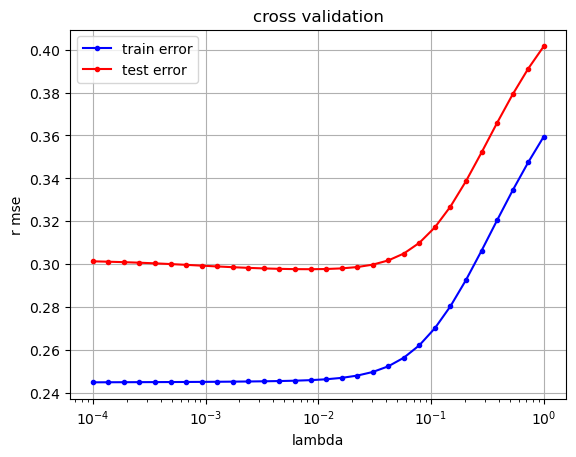

For polynomial expansion up to degree 7, the choice of lambda which leads to the best test rmse is 0.00853 with a test rmse of 0.298


In [94]:
from plots import cross_validation_visualization


def cross_validation_demo(degree, k_fold, lambdas):
    """cross validation over regularisation parameter lambda.

    Args:
        degree: integer, degree of the polynomial expansion
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_lambda : scalar, value of the best lambda
        best_rmse : scalar, the associated root mean squared error for the best lambda
    """

    seed = 12
    degree = degree
    k_fold = k_fold
    lambdas = lambdas
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    best_lambda = None
    best_rmse = None

    for lambda_ in lambdas:
        k_rmse_tr = 0
        k_rmse_te = 0

        for k in range(k_fold):
            last_rmse_tr, last_rmse_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            k_rmse_tr += last_rmse_tr
            k_rmse_te += last_rmse_te

        k_rmse_tr /= k_fold
        k_rmse_te /= k_fold
        rmse_tr.append(k_rmse_tr)
        rmse_te.append(k_rmse_te)

        if best_rmse is None or k_rmse_te < best_rmse:
            best_lambda = lambda_
            best_rmse = k_rmse_te


    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    plt.show()
    print(
        "For polynomial expansion up to degree %.f, the choice of lambda which leads to the best test rmse is %.5f with a test rmse of %.3f"
        % (degree, best_lambda, best_rmse)
    )
    return best_lambda, best_rmse


best_lambda, best_rmse = cross_validation_demo(7, 4, np.logspace(-4, 0, 30))

Your output should look like this for seed = 12, degree = 7 and k_fold = 4:

![alt text](cross_validation2.png)

You can play around with the number of folds and the degree of your polynomial expansion.

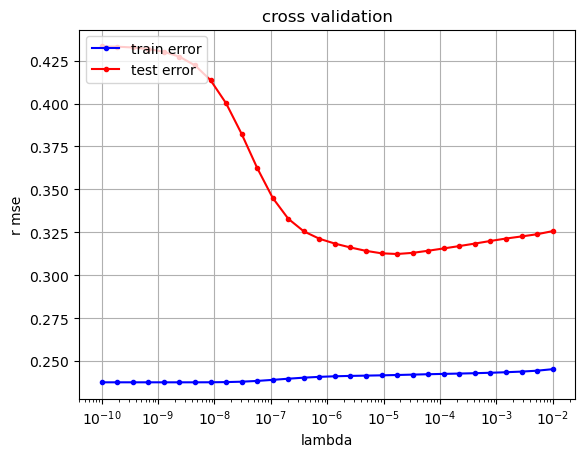

For polynomial expansion up to degree 10, the choice of lambda which leads to the best test rmse is 0.00002 with a test rmse of 0.312


In [95]:
best_lambda, best_rmse = cross_validation_demo(10, 4, np.logspace(-10, -2, 30))

In the previous task we did a grid search over several values of $\lambda$ for a fixed degree. We can also perform a grid search amongst $\lambda$ and degrees simultaneously:

In [131]:
def best_lambda_selection(degree, k_fold, lambdas, seed):
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    best_lambda = None
    best_rmse = None

    for lambda_ in lambdas:
        k_rmse_tr = 0
        k_rmse_te = 0

        for k in range(k_fold):
            last_rmse_tr, last_rmse_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            k_rmse_tr += last_rmse_tr
            k_rmse_te += last_rmse_te

        k_rmse_tr /= k_fold
        k_rmse_te /= k_fold
        rmse_tr.append(k_rmse_tr)
        rmse_te.append(k_rmse_te)

        if best_rmse is None or k_rmse_te < best_rmse:
            best_lambda = lambda_
            best_rmse = k_rmse_te

    return best_lambda, best_rmse


def best_degree_selection(degrees, k_fold, lambdas, seed=1):
    """cross validation over regularisation parameter lambda and degree.

    Args:
        degrees: shape = (d,), where d is the number of degrees to test
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_degree : integer, value of the best degree
        best_lambda : scalar, value of the best lambda
        best_rmse : value of the rmse for the couple (best_degree, best_lambda)

    >>> best_degree_selection(np.arange(2,11), 4, np.logspace(-4, 0, 30))
    (7, 0.004520353656360241, 0.28957280566456634)
    """
    # split data in k fold
    best_degree = None
    best_lambda = None
    best_rmse = None

    for degree in degrees:
        lambda_, rmse = best_lambda_selection(degree, k_fold, lambdas, seed)

        if best_rmse is None or rmse < best_rmse:
            best_degree = degree
            best_lambda = lambda_
            best_rmse = rmse

    return float(best_degree), float(best_lambda), float(best_rmse)


In [132]:
# can lead to a numerical error if you use an older version than Python 3.9
test(best_degree_selection)

best_degree, best_lambda, best_rmse = best_degree_selection(
    np.arange(2, 11), 4, np.logspace(-4, 0, 30)
)
print(
    "The best rmse of %.3f is obtained for a degree of %.f and a lambda of %.5f."
    % (best_rmse, best_degree, best_lambda)
)

❌ The are some issues with your implementation of `best_degree_selection`:
**********************************************************************
File "__main__", line 43, in best_degree_selection
Failed example:
    best_degree_selection(np.arange(2,11), 4, np.logspace(-4, 0, 30))
Expected:
    (7, 0.004520353656360241, 0.28957280566456634)
Got:
    (7.0, 0.004520353656360241, 0.2895728056727541)
**********************************************************************
The best rmse of 0.290 is obtained for a degree of 7 and a lambda of 0.00452.


## Bias-Variance Decomposition

In [134]:
# true function we want to learn
def f_star(x):
    return x**3 - x**2 + 0.5


## plotting function for f_star
def plot_fstar(ax):
    xvals = np.arange(-1, 1, 0.01)
    ax.plot(xvals, f_star(xvals), linestyle="--", color="k", label="f_star")
    ax.set_ylim(-2, 2)

In [135]:
# helper plot function
def plot_poly(x, y, weights, degree, ax, alpha=0.3):
    xvals = np.arange(-1, 1, 0.01)
    tx = build_poly(xvals, degree)
    f = tx.dot(weights)
    ax.plot(xvals, f, color="orange", alpha=alpha, label="fit")
    ax.scatter(x, y, color="b", alpha=alpha, s=10, label="samples")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Polynomial degree " + str(degree))
    ax.set_ylim(-1, 2)


## helper plot function
def plot_f(weights, degree, ax, label=None):
    xvals = np.arange(-1, 1, 0.01)
    tx = build_poly(xvals, degree)
    f = tx.dot(weights)
    ax.plot(xvals, f, color="black", alpha=1, label=label)
    ax.set_ylim(-1, 2)

Implement the following function: for 15 random datapoints, it finds the optimal fit (using the least square formula, with no regularisation λ) for a polynomial expansion of degree 1, 3 and 6.

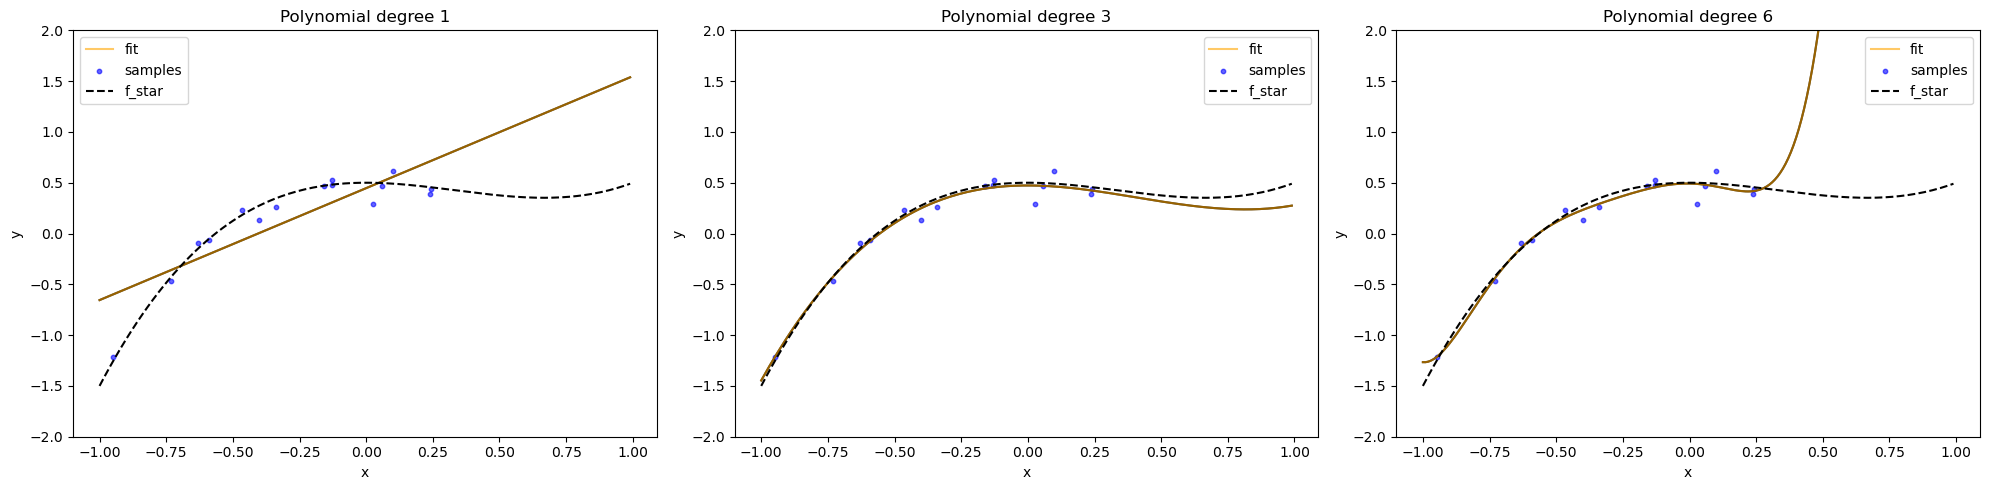

In [137]:
from least_squares import least_squares


def bias_variance_one_seed(sigma, degrees, seed):
    """One run of the optimal fit for 15 random points and different polynomial expansion degrees.

    Args:
        sigma: scalar, noise variance
        degrees: shape = (3,), 3 different degrees to consider
        seed: integer, random see
    Returns:
    """

    # we will generate 15 random datapoints from the [-1, 1] uniform distribuion
    num_data = 15
    np.random.seed(seed)  # set random seed for reproducibility
    xs = np.random.uniform(-1, 1, num_data)
    # the outputs will be f_star(x) + some random gaussian noise of variance sigma**2
    ys = f_star(xs) + sigma * np.random.randn(num_data)

    fig, axs = plt.subplots(1, len(degrees), figsize=(20, 5))
    for index_degree, degree in enumerate(degrees):
        tx = build_poly(xs, degree)
        w, mse = least_squares(ys, tx)

        plot_f(w, degree, axs[index_degree])
        plot_poly(xs, ys, w, degree, axs[index_degree], alpha=0.6)
        plot_fstar(axs[index_degree])
        axs[index_degree].legend()
    plt.tight_layout()
    plt.show()


bias_variance_one_seed(0.1, [1, 3, 6], seed=2)

Your output should ressemble (for seed = 2) to this: 
![alt text](bias_variance_one_run.png)

Now to illustrate the bias variance tradeoff we will repeat many times the previous experiment but using a different random seed each time. We also plot (in plain black) the mean of all the orange functions obtained.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

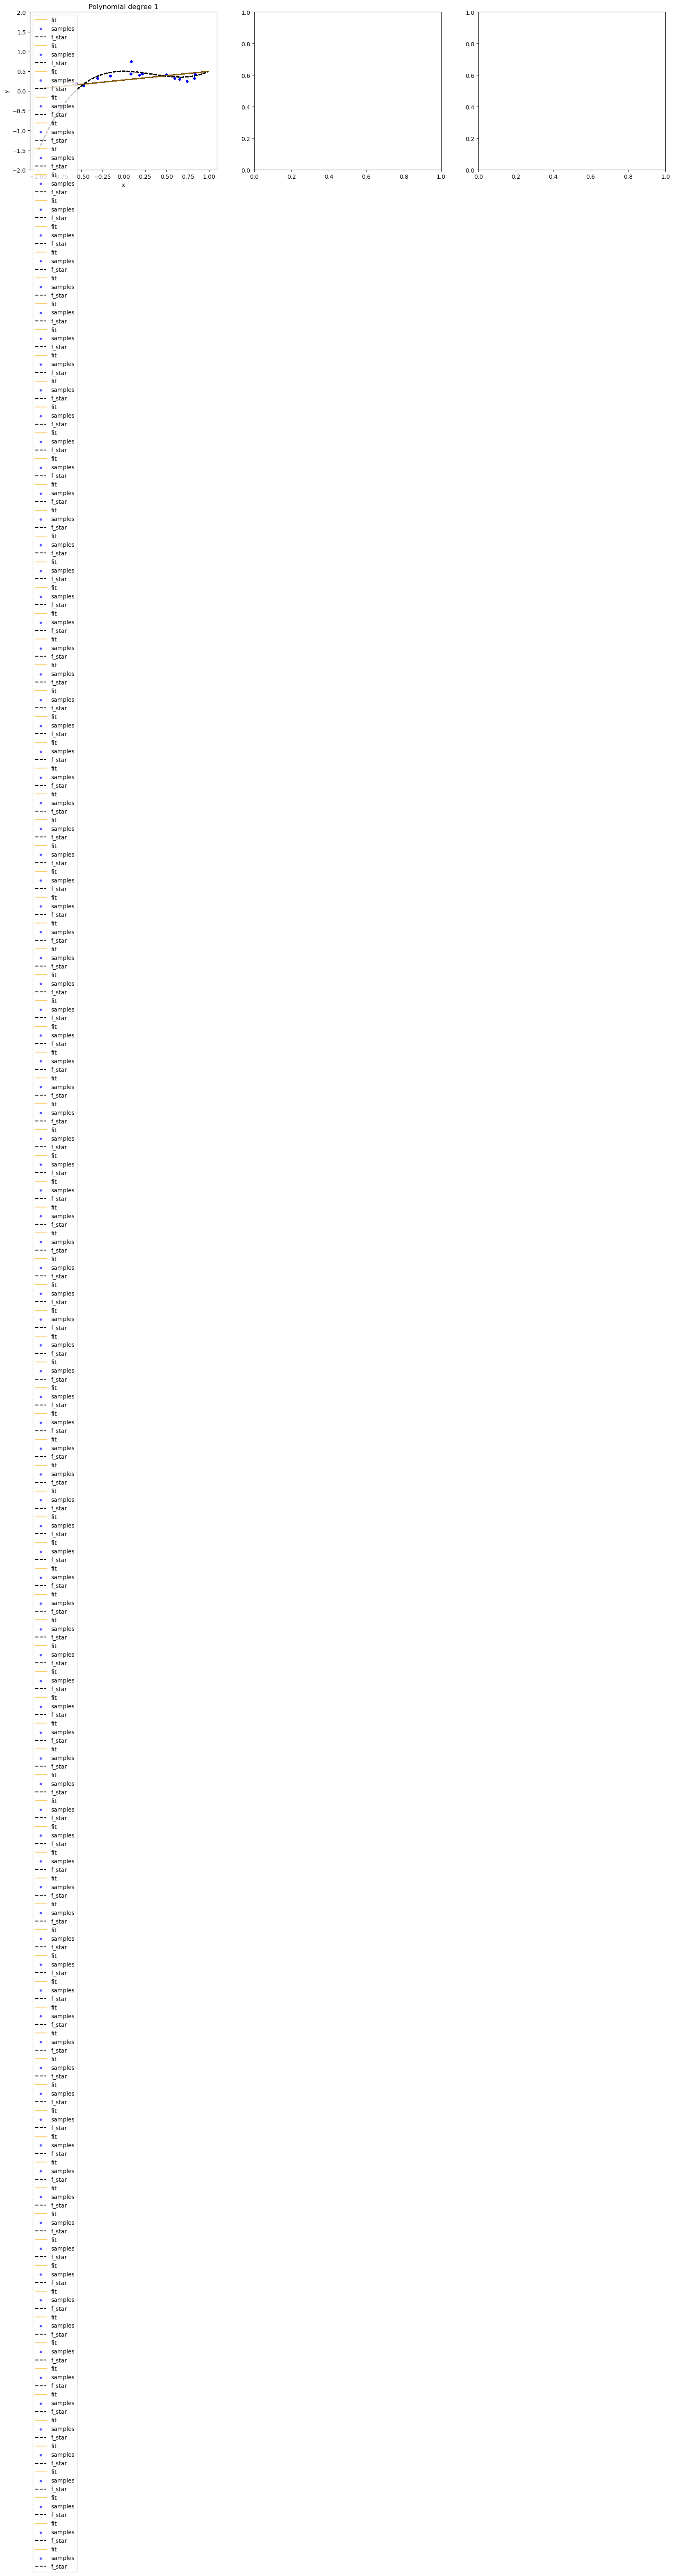

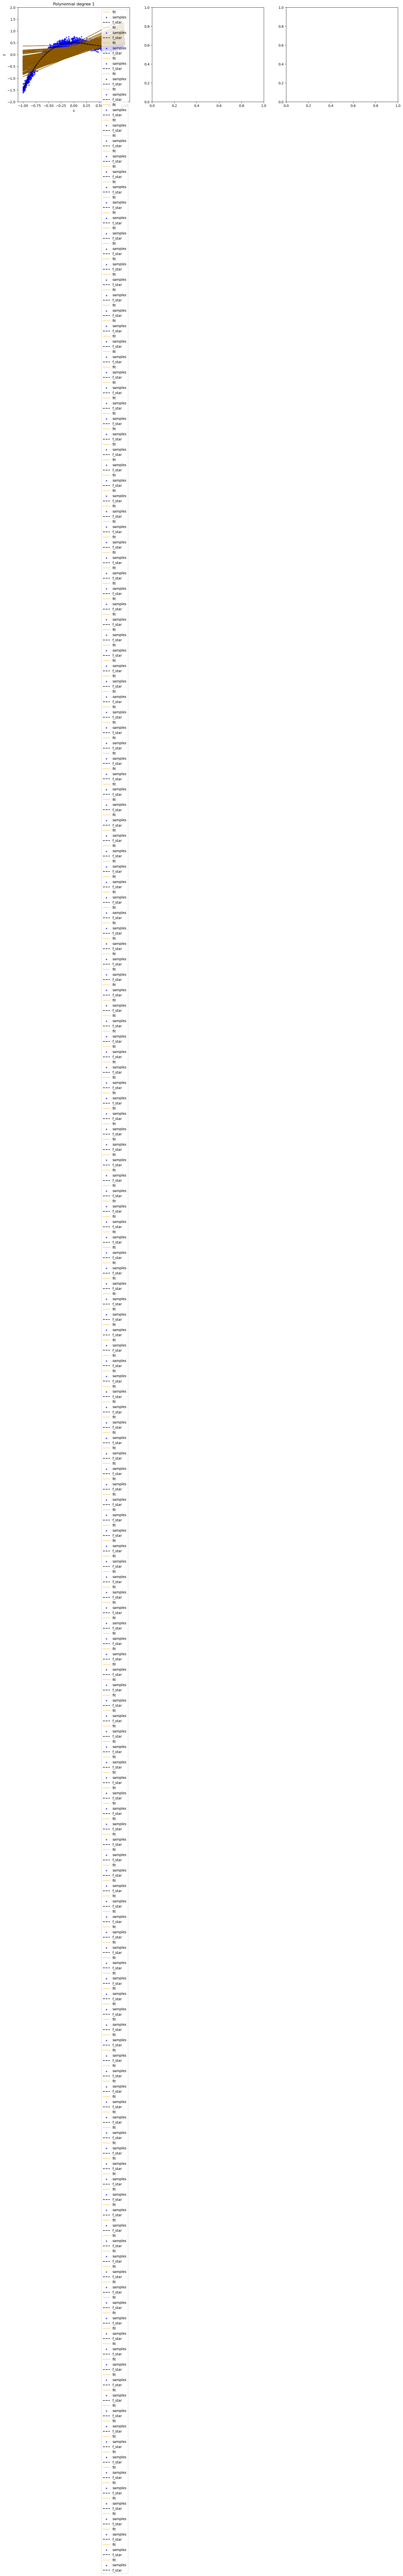

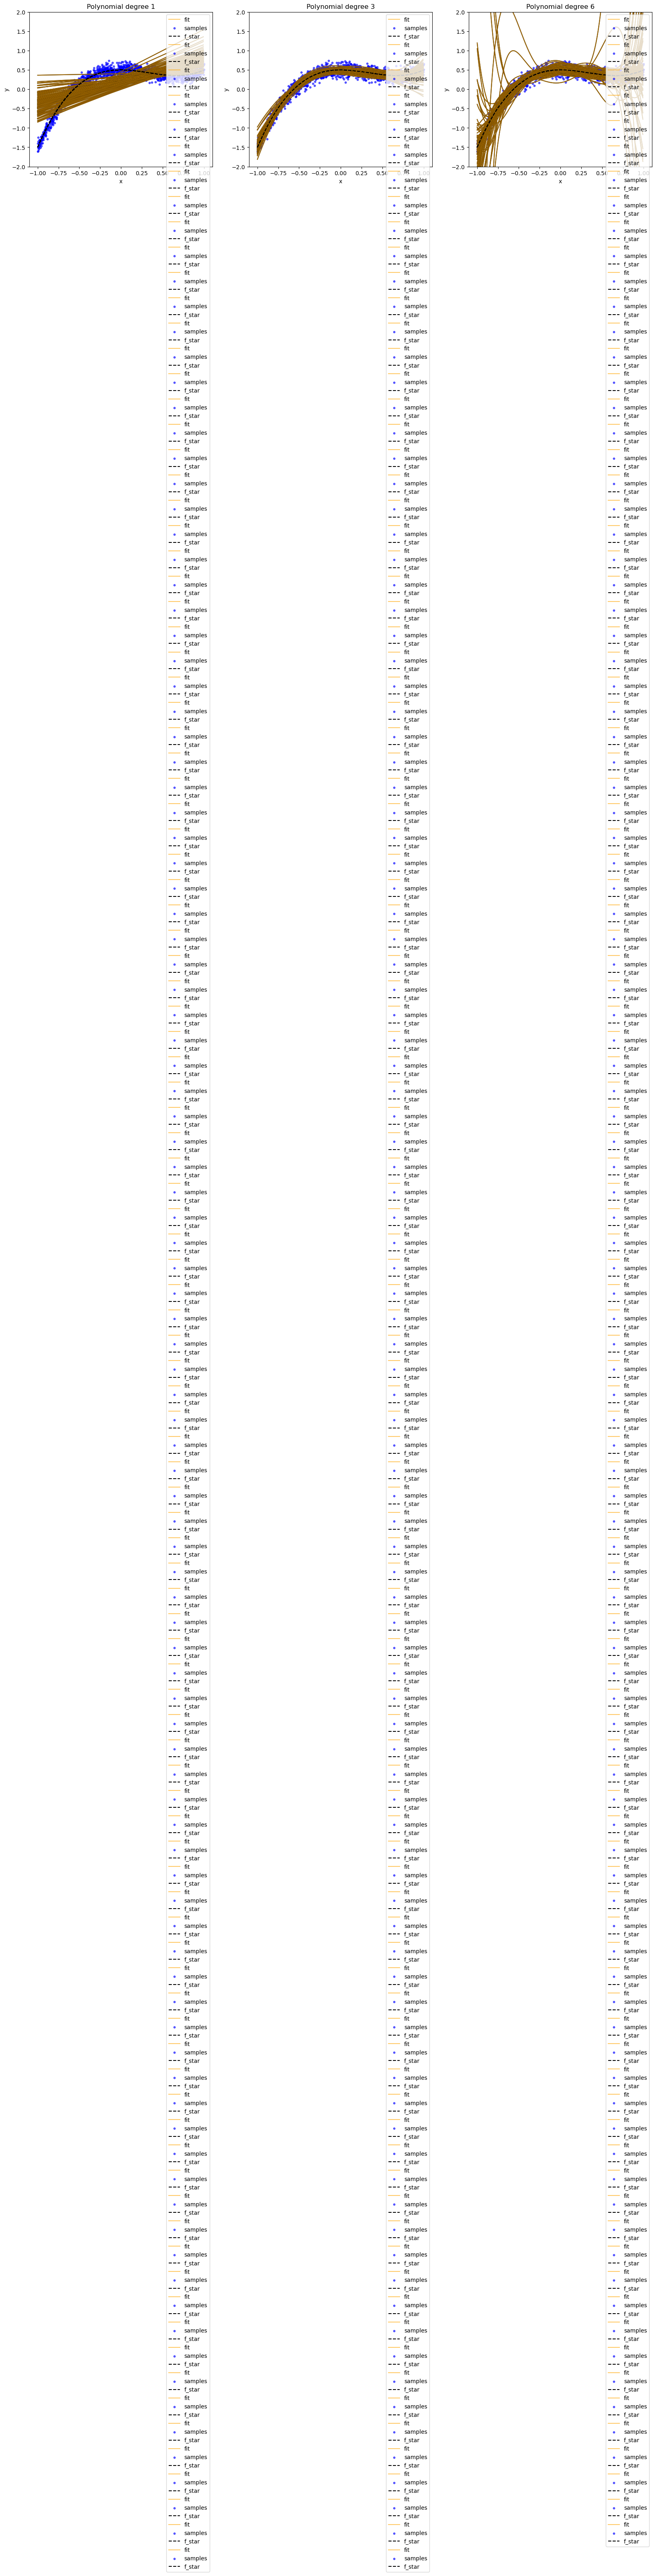

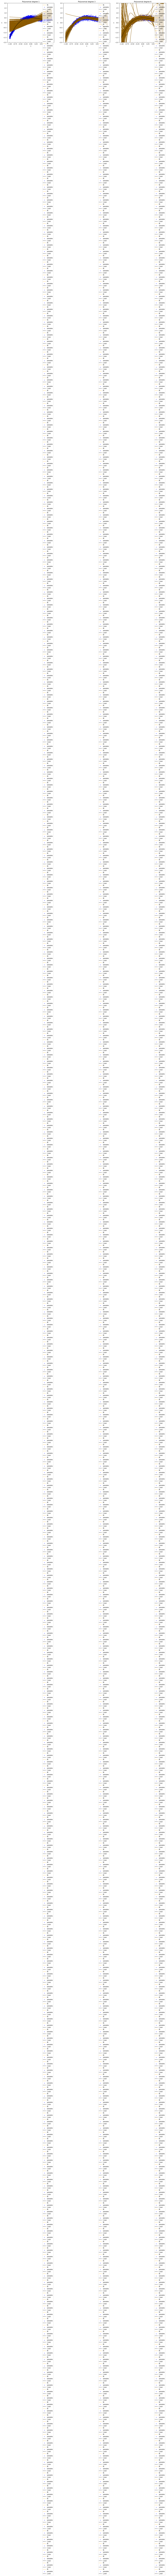

In [144]:
def bias_variance_demo(sigma, degrees):
    """Illustration of the bias-variance tradeoff.

    Args:
        sigma: scalar, noise variance
        degrees: shape = (3,), 3 different degrees to consider
    Returns:
    """
    # define parameters
    seeds = range(400)  # number of runs
    num_data = 15

    fig, axs = plt.subplots(1, len(degrees), figsize=(20, 5))
    for seed in seeds:
        np.random.seed(seed)
        print(seed)
        xs = np.random.uniform(-1, 1, num_data)
        ys = f_star(xs) + sigma * np.random.randn(num_data)

        for index_degree, degree in enumerate(degrees):
            tx = build_poly(xs, degree)
            w, mse = least_squares(ys, tx)

            plot_f(w, degree, axs[index_degree])
            plot_poly(xs, ys, w, degree, axs[index_degree], alpha=0.6)
            plot_fstar(axs[index_degree])
            axs[index_degree].legend()
    plt.show()


bias_variance_demo(0.1, [1, 3, 6])

Your output should ressemble to this: 
![alt text](bias_variance.png)